# Overfitting and Regularization

In [1]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

pd.options.mode.chained_assignment = None

# Bias vs Variance

See here: <a href="https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BC%D0%BF%D1%80%D0%BE%D0%BC%D1%96%D1%81_%D0%B7%D1%81%D1%83%D0%B2%D1%83_%D1%82%D0%B0_%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D1%96%D1%97">Компроміс зсуву та дисперсії</a>

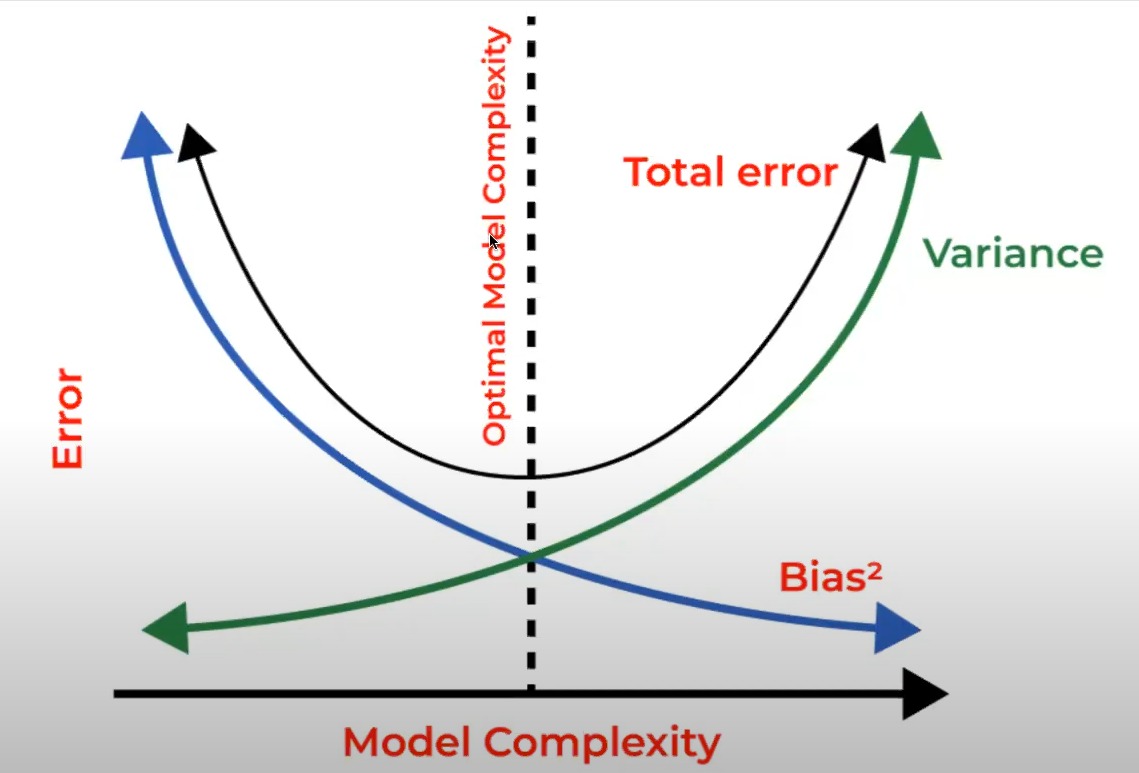

# Overfitting

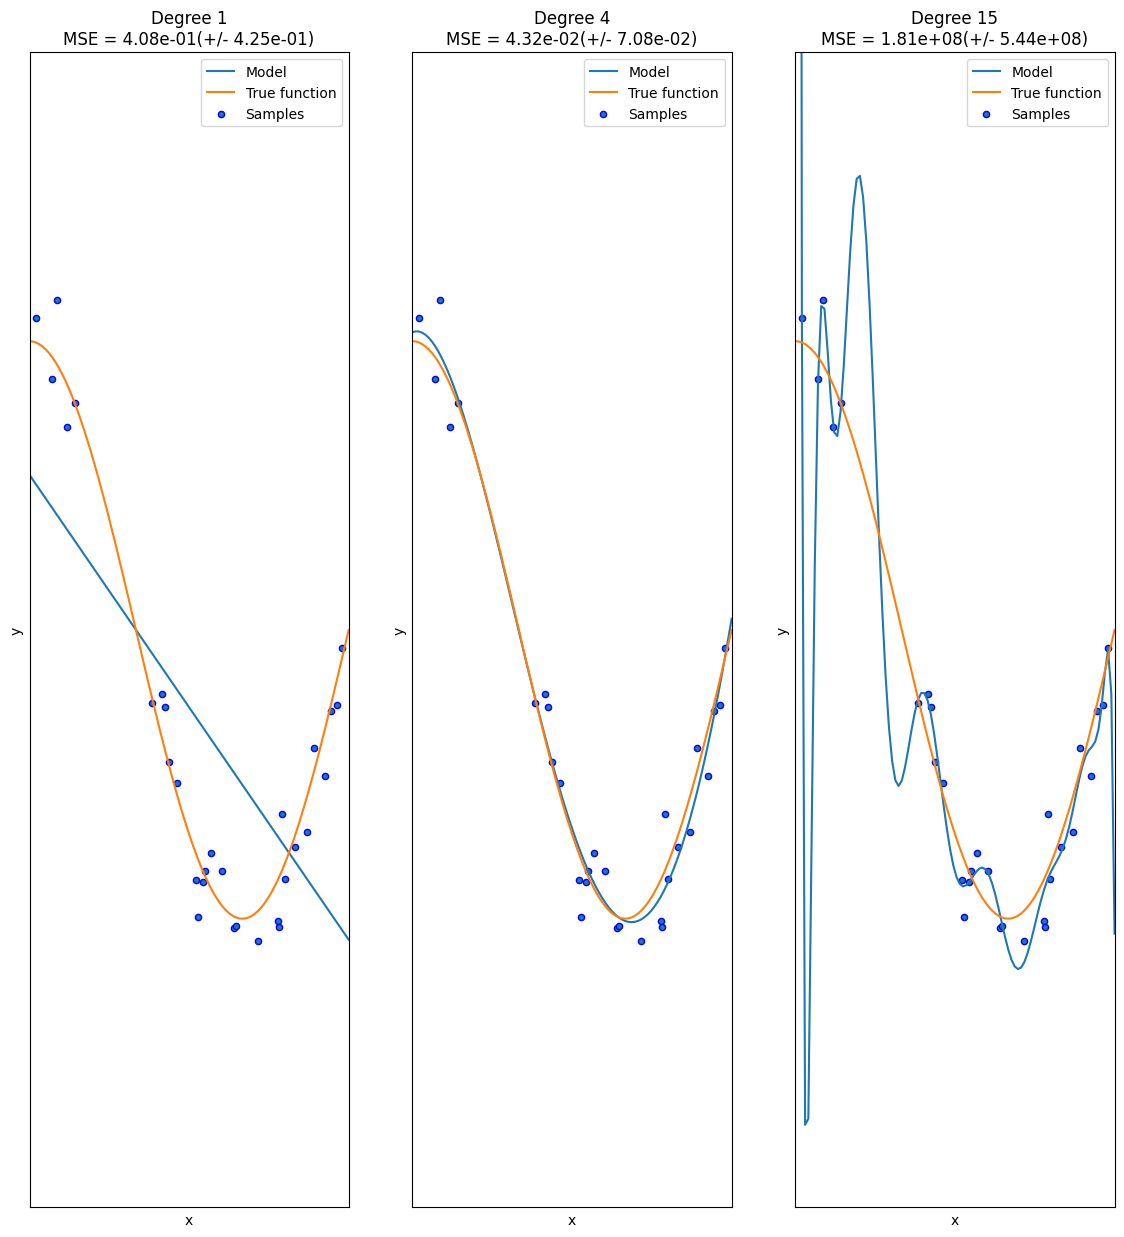

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

def true_fun(X):
    return np.cos(1.5*np.pi*X)

np.random.seed(0)

n_samples = 30
degrees = [1 ,4, 15]

X = np.sort(np.random.rand(n_samples)) 
y = true_fun(X) + np.random.randn(n_samples)*0.1

plt.figure(figsize=(14, 15))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks = (), yticks=())
    
    polynomal_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomal_features", polynomal_features),
            ("linear_regression", linear_regression)
        ]
    )
    
    pipeline.fit(X[:, np.newaxis], y)
    
    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolors='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

# Train-test split
We will use the Kaggle Food Demand Forecasting dat to demonstrate these major steps

* https://www.kaggle.com/datasets/kannanaikkal/food-demand-forecasting/ (trains csv)

In [3]:
PATH = "../../data/food_demand"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
#test_data = pd.read_csv(os.path.join(PATH, 'test.csv'), index_col=0)

meal_info_df = pd.read_csv(os.path.join(PATH, "meal_info.csv"), index_col=0)
meal_info_df = meal_info_df.reset_index(drop=False)

meal_info_df[["category", "meal_id"]].groupby(["category"]).count()
df = df.merge(meal_info_df, on='meal_id', how='left')

df.head()


,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian


In [4]:
df.tail()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
456543,145,61,1543,484.09,484.09,0,0,68,Desert,Indian
456544,145,61,2304,482.09,482.09,0,0,42,Desert,Indian
456545,145,61,2664,237.68,321.07,0,0,501,Salad,Italian
456546,145,61,2569,243.50,313.34,0,0,729,Salad,Italian
456547,145,61,2490,292.03,290.03,0,0,162,Salad,Italian


In [5]:
df.cuisine.unique()
#df['cuisine'].unique()

<StringArray>
['Thai', 'Indian', 'Italian', 'Continental']
Length: 4, dtype: str

In [6]:
df_slice = df[(df['center_id']==55) & (df['cuisine']=="Thai")]
df_slice = df_slice[['checkout_price', 'num_orders']]

# sorted by checkout price
df_slice = df_slice.sort_values(by='checkout_price', axis=0, ascending=False)
df_slice.reset_index(inplace=True, drop=True)
df_slice

,checkout_price,num_orders
0,321.13,28
1,321.13,27
2,321.13,41
3,321.13,13
4,321.13,26
...,...,...
1274,80.54,54
1275,80.54,53
1276,80.54,55
1277,79.54,53


In [7]:
# train-test-split with sklearn
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_slice, shuffle=False, test_size=0.25)
train_data.head()

,checkout_price,num_orders
0,321.13,28
1,321.13,27
2,321.13,41
3,321.13,13
4,321.13,26


In [8]:
test_data.tail()

,checkout_price,num_orders
1274,80.54,54
1275,80.54,53
1276,80.54,55
1277,79.54,53
1278,79.54,55


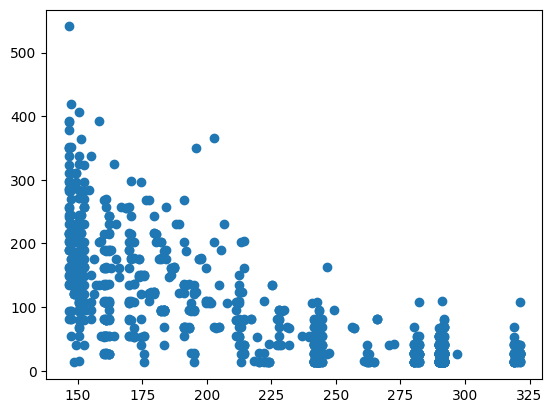

In [9]:
plt.scatter(train_data["checkout_price"], train_data['num_orders'])

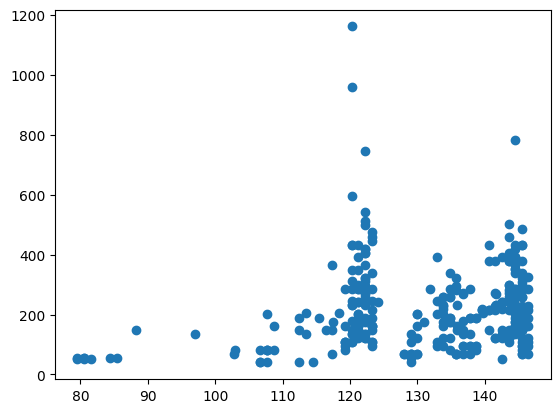

In [10]:
plt.scatter(test_data["checkout_price"], test_data["num_orders"])

In [11]:
from sklearn.linear_model import LinearRegression

x = train_data["checkout_price"].to_numpy().reshape(-1,1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x,y)

In [12]:
train_data["predictions"] = model.predict(x)

x_test = test_data['checkout_price'].to_numpy().reshape(-1,1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

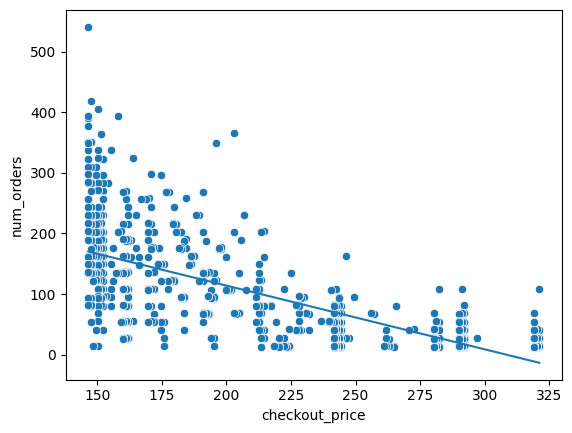

In [13]:
# Train
sns.scatterplot(x='checkout_price', y='num_orders', data = train_data)
sns.lineplot(data=train_data, x='checkout_price', y = 'predictions')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

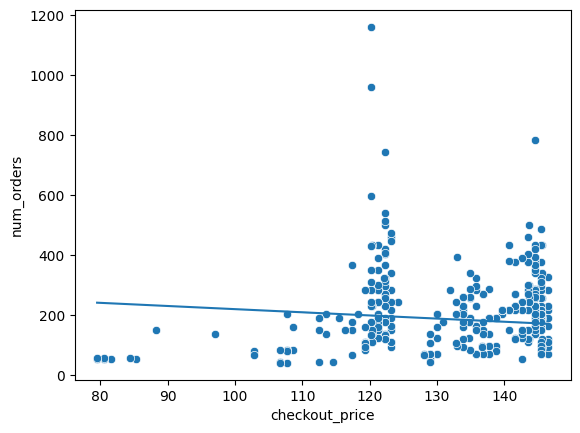

In [14]:
# Test
sns.scatterplot(x='checkout_price', y='num_orders', data =test_data)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error_train = mean_squared_error(train_data['num_orders'], train_data['predictions'])
print(f'Train {mean_squared_error_train=}')
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data['predictions'])
print(f'Test {mean_squared_error_test=}')

Train mean_squared_error_train=3606.2784562593893
Test mean_squared_error_test=20230.476494162875


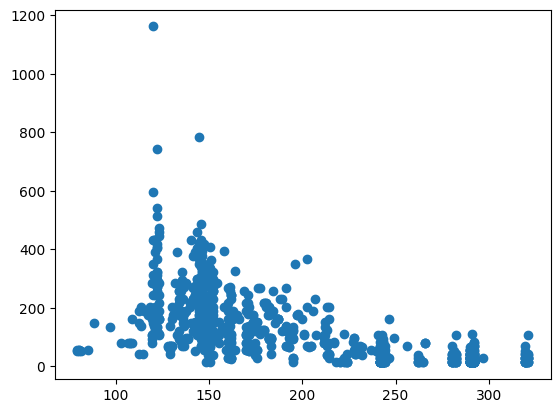

In [16]:
# Shuffle the data
train_data, test_data = train_test_split(df_slice, shuffle=True, test_size=0.25)

plt.scatter(train_data["checkout_price"], train_data['num_orders'])

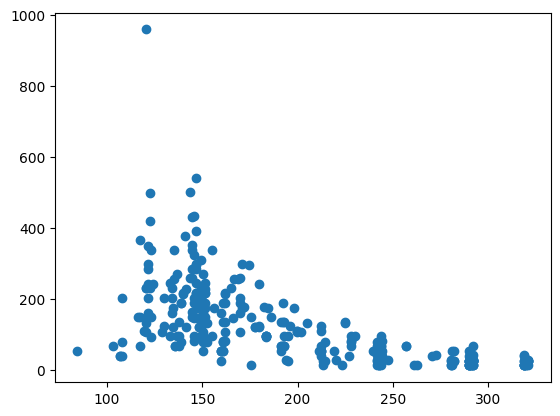

In [17]:
plt.scatter(test_data["checkout_price"], test_data["num_orders"])

In [18]:
x = train_data["checkout_price"].to_numpy().reshape(-1,1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x,y)
train_data["predictions"] = model.predict(x)

x_test = test_data['checkout_price'].to_numpy().reshape(-1,1)
test_data["predictions"] = model.predict(x_test)

<Axes: xlabel='checkout_price', ylabel='num_orders'>

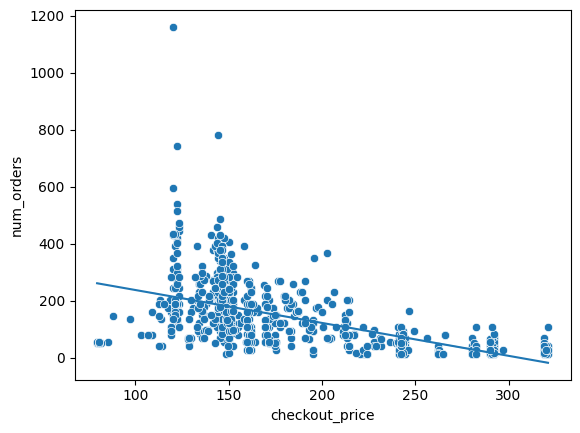

In [19]:
sns.scatterplot(x='checkout_price', y='num_orders', data = train_data)
sns.lineplot(data=train_data, x='checkout_price', y = 'predictions')

<Axes: xlabel='checkout_price', ylabel='num_orders'>

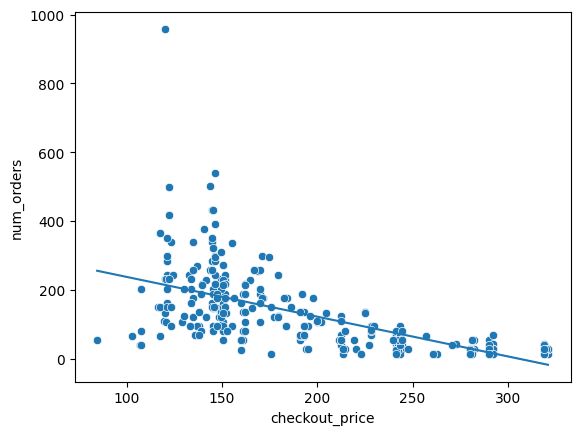

In [20]:
sns.scatterplot(x='checkout_price', y='num_orders', data = test_data)
sns.lineplot(data=test_data, x='checkout_price', y = 'predictions')

In [21]:
mean_squared_error_train = mean_squared_error(train_data['num_orders'], train_data['predictions'])
print(f'Train {mean_squared_error_train=}')
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data['predictions'])
print(f'Test {mean_squared_error_test=}')

Train mean_squared_error_train=7731.297071028298
Test mean_squared_error_test=7484.561595717113


# Cross Validation
https://scikit-learn.org/stable/modules/cross_validation.html

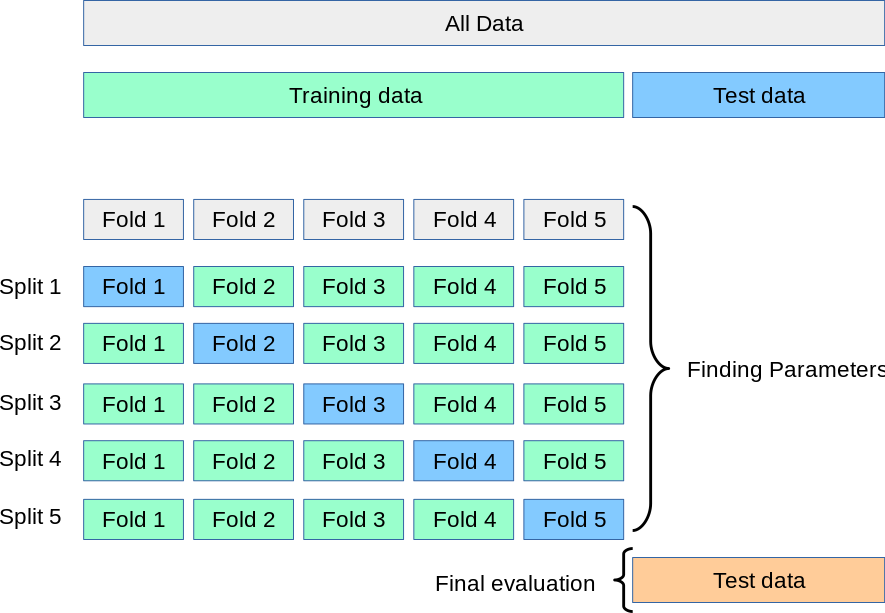

In [22]:
from sklearn import model_selection

X = range(10)

In [23]:
kf = model_selection.KFold(n_splits=5)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)
    
print()
    
kf = model_selection.KFold(n_splits=2, shuffle=True)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)

print()

kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=1)
for train_indices, test_indices in kf.split(X):
    print(train_indices, test_indices)


[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]

[0 1 3 5 8] [2 4 6 7 9]
[2 4 6 7 9] [0 1 3 5 8]

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


In [24]:
X = range(12)

y = np.array([0]*6 + [1]*6)
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print(train_indices, test_indices)

[0 0 0 0 0 0 1 1 1 1 1 1]
[ 0  3  5  7  8 11] [ 1  2  4  6  9 10]
[ 1  2  4  6  9 10] [ 0  3  5  7  8 11]


In [25]:
y = np.array([0,1]*6)
print(y)

skf = model_selection.StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
for train_indices, test_indices in skf.split(X, y):
    print(train_indices, test_indices)

[0 1 0 1 0 1 0 1 0 1 0 1]
[ 0  3  5  6 10 11] [1 2 4 7 8 9]
[1 2 4 7 8 9] [ 0  3  5  6 10 11]


In [26]:
ss = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
for train_indices, test_indices in ss.split(X):
    print(train_indices, test_indices)

[ 6  5  8 11  4  1  0  7 10] [3 9 2]
[ 3 11  6  2  8  9  4  5 10] [0 1 7]
[ 6  7  5 10  1  9  8  0  3] [ 2  4 11]
[ 6 11 10  0  4  5  9  3  2] [7 8 1]
[ 5  7  6 10  0 11  4  1  8] [2 3 9]
[ 4  7  8  5  6 10  3  0  9] [ 2 11  1]
[ 9  0 10  3  1  2 11  5  8] [4 6 7]
[ 4  0  9  1 11  7  2  6  8] [ 3  5 10]
[ 8  4  9  0  1  2 11  3 10] [5 7 6]
[ 9  4 10  8  7  1 11  2  3] [0 6 5]


In [27]:
X = range(10)
target = np.array([0]*5 + [1]*5)
print(target )
print()

sss = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.2)
for train_indices, test_indices in sss.split(X, target):
    print(train_indices, test_indices)


[0 0 0 0 0 1 1 1 1 1]

[2 5 4 1 6 7 9 3] [8 0]
[4 6 8 7 5 2 0 3] [9 1]
[7 8 4 6 0 1 3 9] [2 5]
[9 4 0 2 6 7 8 1] [5 3]


In [28]:
loo = model_selection.LeaveOneOut()

for train_indices, test_indices in loo.split(X):
    print(train_indices, test_indices)


[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


# Regularization

Ridge Regression: In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coeficients. 

Classic linear regression:
$$
\hat{y} = \beta[0] \times x[0] + \beta[1] \times x[1] + \dots + \beta[n] \times x[n] + b \quad \text{Eqn 1.1}
$$

Sum of squares in classic linear regression:
$$
\sum_{i=1}^{M} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{M} \left( y_i - \sum_{j=0}^{p} \beta_j \times x_{ij} \right)^2 \quad \text{Eqn 1.2}
$$

### Lasso (L1)
$$
L_{\text{Lasso}}(\hat{\beta}) = \sum_{i=1}^{n} (y_i - x_i \hat{\beta})^2 + \lambda \sum_{j=1}^{m} |\hat{\beta}_j|
$$

### Ridge (L2)

$$
SSE_{\text{L}_{\text{2}}} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{P} \beta_j^2
$$



<Axes: xlabel='checkout_price', ylabel='num_orders'>

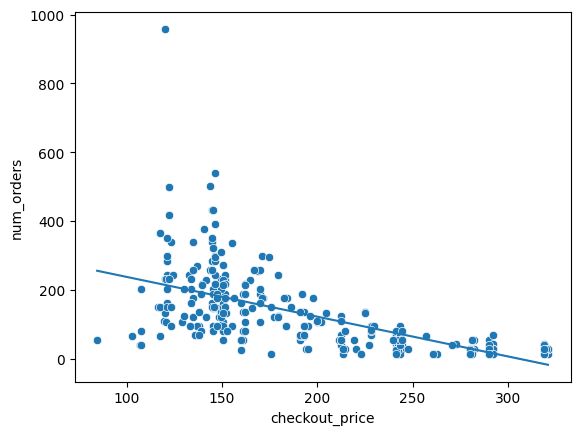

In [29]:
x = train_data["checkout_price"].to_numpy().reshape(-1,1)
y = train_data["num_orders"].to_numpy()

model = LinearRegression().fit(x,y)
train_data["predictions"] = model.predict(x)

x_test = test_data['checkout_price'].to_numpy().reshape(-1,1)
test_data["predictions"] = model.predict(x_test)

sns.scatterplot(x='checkout_price', y='num_orders', data = test_data)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')

In [30]:
mean_squared_error_test = mean_squared_error(test_data["num_orders"], test_data['predictions'])
print(f'Test {mean_squared_error_test=}')

Test mean_squared_error_test=7484.561595717113


In [31]:
model.coef_ # Параметер бета у формулі лінійної регресії

array([-1.15471077])

In [32]:
from copy import deepcopy
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

models = []
for coef in coefs:
    new_model = deepcopy(model)
    new_model.coef_ = np.array([coef])
    models.append(new_model)
    
for i in range(len(models)):
    test_data[f"exp_{i}"] = models[i].predict(x_test)

pd.melt(test_data.drop(['num_orders'], axis=1), ['checkout_price'])

,checkout_price,variable,value
0,144.53,predictions,186.192045
1,139.68,predictions,191.792393
2,179.51,predictions,145.800263
3,319.13,predictions,-15.420456
4,291.03,predictions,17.026917
...,...,...,...
5755,123.25,exp_16,500.982393
5756,223.13,exp_16,620.838393
5757,165.93,exp_16,552.198393
5758,239.59,exp_16,640.590393


<Axes: xlabel='checkout_price', ylabel='num_orders'>

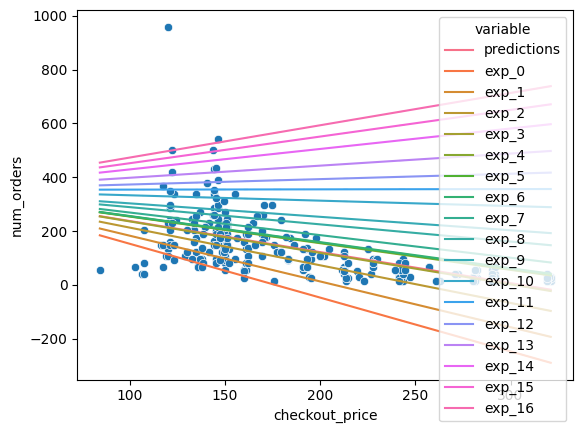

In [33]:
sns.scatterplot(x='checkout_price', y='num_orders', data = test_data)
sns.lineplot(x='checkout_price', y='value', hue='variable', data = pd.melt(test_data.drop(['num_orders'], axis=1), ['checkout_price']))

Model 0, coef=[-2.], Test MSE=37320.42969967409
Model 1, coef=[-1.7], Test MSE=19679.01845964387
Model 2, coef=[-1.4], Test MSE=9797.62087938867
Model 3, coef=[-1.16981158], Test MSE=7477.105271260521
Model 4, coef=[-0.99], Test MSE=8842.710721709347
Model 5, coef=[-0.98], Test MSE=9000.487215453384
Model 6, coef=[-0.97], Test MSE=9166.885946597171
Model 7, coef=[-0.84], Test MSE=12114.693054843621
Model 8, coef=[-0.64], Test MSE=19495.119255601814
Model 9, coef=[-0.5], Test MSE=26713.510097273054
Model 10, coef=[-0.2], Test MSE=47872.167156117845
Model 11, coef=[0.01], Test MSE=67300.43522487531
Model 12, coef=[0.2], Test MSE=88154.84226089423
Model 13, coef=[0.45], Test MSE=120337.08208867637
Model 14, coef=[0.76], Test MSE=167727.16153810918
Model 15, coef=[0.99], Test MSE=208241.95249035247
Model 16, coef=[1.2], Test MSE=249217.1918210852


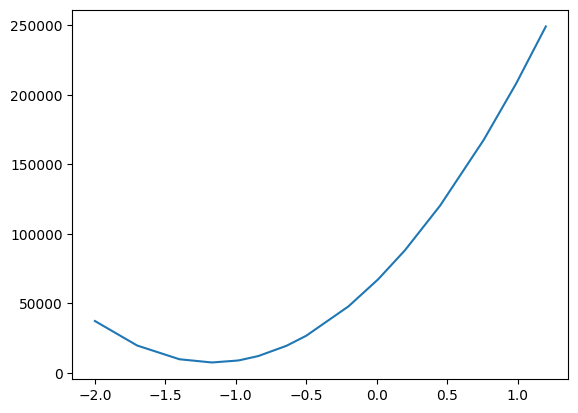

In [34]:
losses = []
for i, model in enumerate(models):
    losses.append(mean_squared_error(test_data["num_orders"], test_data[f"exp_{i}"]))
    print(f'Model {i}, coef={models[i].coef_}, Test MSE={losses[-1]}')

plt.plot(np.array(coefs), np.array(losses), label='MSE')

Optimal alpha: 4.513105888563535


<Axes: xlabel='checkout_price', ylabel='num_orders'>

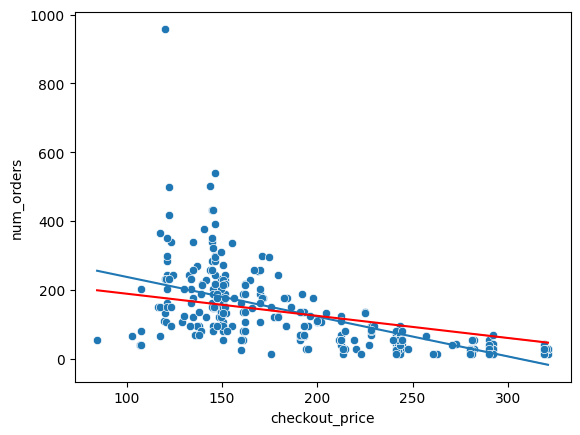

In [35]:
from sklearn.linear_model import Ridge, Lasso, LassoCV

lasso_cv = LassoCV(cv=5).fit(x,y)
print(f'Optimal alpha: {lasso_cv.alpha_}')

#model_lasso = Lasso(alpha=lasso_cv.alpha_).fit(x,y)
model_lasso = Lasso(alpha=2000.0).fit(x,y)

test_data_lasso = test_data[:]

test_data_lasso["predictions"] = model_lasso.predict(x_test)

sns.scatterplot(x='checkout_price', y='num_orders', data = test_data_lasso)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')
sns.lineplot(data=test_data_lasso, x='checkout_price', y='predictions', color='red')

In [36]:
test_data.head()

,checkout_price,num_orders,predictions,exp_0,exp_1,exp_2,exp_3,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,exp_14,exp_15,exp_16
1039,144.53,163,186.192045,64.022393,107.381393,150.740393,184.009526,209.997693,211.442993,212.888293,231.677193,260.583193,280.817393,324.176393,354.527693,381.988393,418.120893,462.925193,496.167093,526.518393
1084,139.68,216,191.792393,73.722393,115.626393,157.530393,189.683112,214.799193,216.195993,217.592793,235.751193,263.687193,283.242393,325.146393,354.479193,381.018393,415.938393,459.239193,491.365593,520.698393
597,179.51,243,145.800263,-5.937607,47.915393,101.768393,143.089517,175.367493,177.162593,178.957693,202.293993,238.195993,263.327393,317.180393,354.877493,388.984393,433.861893,489.509993,530.797293,568.494393
31,319.13,42,-15.420456,-285.177607,-189.438607,-93.699607,-20.239576,37.143693,40.334993,43.526293,85.013193,148.839193,193.517393,289.256393,356.273693,416.908393,496.690893,595.621193,669.021093,736.038393
142,291.03,14,17.026917,-228.977607,-141.668607,-54.359607,12.632129,64.962693,67.872993,70.783293,108.617193,166.823193,207.567393,294.876393,355.992693,411.288393,484.045893,574.265193,641.202093,702.318393


In [37]:
mean_squared_error_test_lasso = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso['predictions'])
print(f'Test Lasso {mean_squared_error_test_lasso=}')

Test Lasso mean_squared_error_test_lasso=8378.208557327254


Model 0, coef=[-2.], Test MSE=80087.17891079409
Model 1, coef=[-1.7], Test MSE=50563.49154586131
Model 2, coef=[-1.4], Test MSE=28799.81784070354
Model 3, coef=[-1.16981158], Test MSE=17362.09434192525
Model 4, coef=[-0.99], Test MSE=11605.796978990724
Model 5, coef=[-0.98], Test MSE=11367.497601904672
Model 6, coef=[-0.97], Test MSE=11137.820462218373
Model 7, coef=[-0.84], Test MSE=8936.641249673714
Model 8, coef=[-0.64], Test MSE=8395.550033830204
Model 9, coef=[-0.5], Test MSE=10068.878683880248
Model 10, coef=[-0.2], Test MSE=19345.259617822478
Model 11, coef=[0.01], Test MSE=30455.93439914817
Model 12, coef=[0.2], Test MSE=43784.899889395456
Model 13, coef=[0.45], Test MSE=66065.24294642545
Model 14, coef=[0.76], Test MSE=101176.97040012563
Model 15, coef=[0.99], Test MSE=132582.01632327697
Model 16, coef=[1.2], Test MSE=165239.6623665779


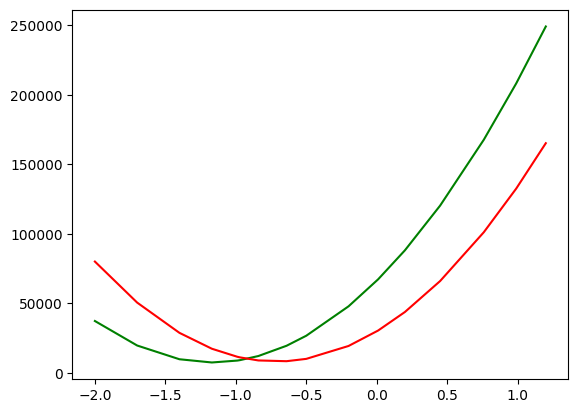

In [38]:
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

models_lasso = []
for coef in coefs:
    new_model = deepcopy(model_lasso)
    new_model.coef_ = np.array([coef])
    models_lasso.append(new_model)
    
for i in range(len(models_lasso)):
    test_data_lasso[f"exp_{i}"] = models_lasso[i].predict(x_test)
    
losses_lasso = []
for i, model in enumerate(models_lasso):
    losses_lasso.append(mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp_{i}"]))
    print(f'Model {i}, coef={models_lasso[i].coef_}, Test MSE={losses_lasso[-1]}')

plt.plot(np.array(coefs), np.array(losses), label='MSE', color='green')
plt.plot(np.array(coefs), np.array(losses_lasso), label='MSE', color='red')


/home/serhii/Documents/DataScience/DSLectures/DataScience_sandbox/.ds_lec_env/lib/python3.14/site-packages/sklearn/base.py:1336: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/serhii/Documents/DataScience/DSLectures/DataScience_sandbox/.ds_lec_env/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:716: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/serhii/Documents/DataScience/DSLectures/DataScience_sandbox/.ds_lec_env/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.707e+06, tolerance: 1.241e+03
Linear regression models 

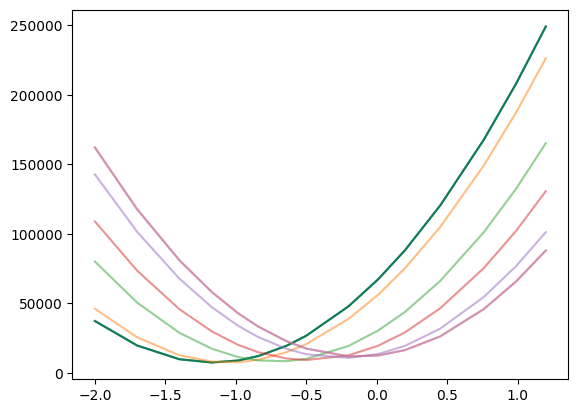

In [39]:
plt.plot(np.array(coefs), np.array(losses), label='MSE', color='green')
losses_lasso_all = [losses]

for i in [0, 500, 2000, 3000, 4000, 5000, 10000]:
    model_lasso = Lasso(alpha=i).fit(x,y)
    
    x_test = test_data_lasso['checkout_price'].to_numpy().reshape(-1,1)
    test_data_lasso["predictions"] = model_lasso.predict(x_test)
    #mean_squared_error_test_lasso = mean_squared_error(test_data_lasso["num_orders"], test_data_lasso['predictions'])
    #print(f'Alpha {i}, Test Lasso {mean_squared_error_test_lasso=}')
    
    models_lasso = []
    for coef in coefs:
        new_model = deepcopy(model_lasso)
        new_model.coef_ = np.array([coef])
        models_lasso.append(new_model)
        
    for j in range(len(models_lasso)):
        test_data_lasso[f"exp_{j}"] = models_lasso[j].predict(x_test)
        
    losses_lasso = []
    for j, model in enumerate(models_lasso):
        losses_lasso.append(mean_squared_error(test_data_lasso["num_orders"], test_data_lasso[f"exp_{j}"]))
        #print(f'Model {j}, coef={models_lasso[j].coef_}, Test MSE={losses_lasso[-1]}')
    
    losses_lasso_all.append(losses_lasso)
    plt.plot(np.array(coefs), np.array(losses_lasso), label='MSE', alpha=0.5)

In [40]:
losses_lasso_all

[[37320.42969967409,
  19679.01845964387,
  9797.62087938867,
  7477.105271260521,
  8842.710721709347,
  9000.487215453384,
  9166.885946597171,
  12114.693054843621,
  19495.119255601814,
  26713.510097273054,
  47872.167156117845,
  67300.43522487531,
  88154.84226089423,
  120337.08208867637,
  167727.16153810918,
  208241.95249035247,
  249217.1918210852],
 [37320.42969967412,
  19679.0184596439,
  9797.62087938868,
  7477.105271260521,
  8842.71072170934,
  9000.487215453375,
  9166.885946597158,
  12114.693054843607,
  19495.119255601792,
  26713.51009727302,
  47872.1671561178,
  67300.43522487527,
  88154.84226089418,
  120337.08208867628,
  167727.1615381091,
  208241.95249035239,
  249217.1918210851],
 [46138.70072487237,
  25526.720453616505,
  12674.753842135655,
  8074.936261344966,
  7660.066008447949,
  7718.8235344844625,
  7786.203297920726,
  9446.763825969398,
  14846.810672577161,
  20678.935966343095,
  38867.02399396224,
  56215.89374086177,
  75188.94039043777,


Test Ridge mean_squared_error_test_ridge=7484.420011371573


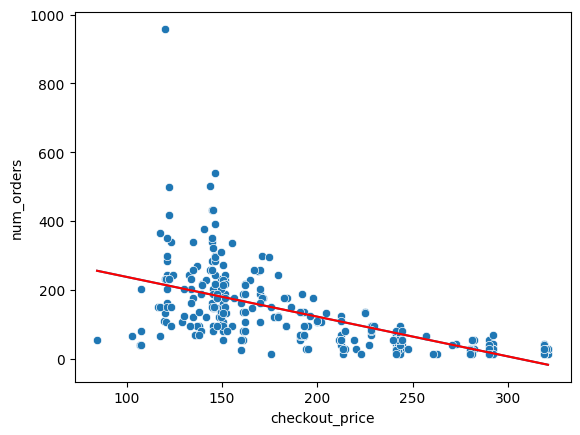

In [41]:
model_ridge = Ridge(alpha=2000.0).fit(x,y)

test_data_ridge = test_data[:]

x_test = test_data_ridge['checkout_price'].to_numpy().reshape(-1,1)
test_data_ridge["predictions"] = model_ridge.predict(x_test)

sns.scatterplot(x='checkout_price', y='num_orders', data = test_data_ridge)
sns.lineplot(data=test_data, x='checkout_price', y='predictions')
sns.lineplot(data=test_data_ridge, x='checkout_price', y='predictions', color='red')

mean_squared_error_test_ridge = mean_squared_error(test_data_ridge["num_orders"], test_data_ridge['predictions'])
print(f'Test Ridge {mean_squared_error_test_ridge=}')

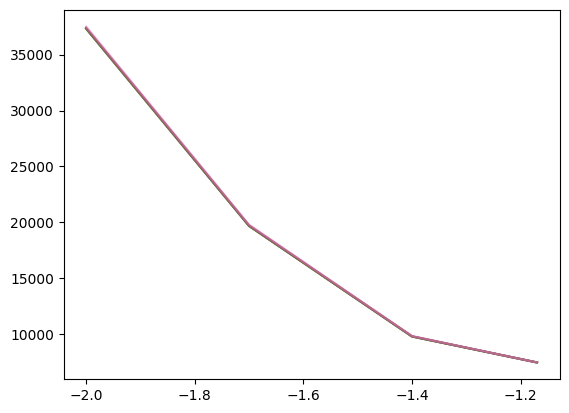

In [42]:
plt.plot(np.array(coefs[:4]), np.array(losses[:4]), label='MSE', color='green')
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

losses_ridge_all = [losses]

#test_data_ridge = train_data[:]
for i in [0, 500, 2000, 3000, 4000, 5000, 10000]:
    model_ridge = Ridge(alpha=i).fit(x,y)

    x_test = test_data_ridge['checkout_price'].to_numpy().reshape(-1,1)
    test_data_ridge["predictions"] = model_ridge.predict(x_test)
    mean_squared_error_test_ridge = mean_squared_error(test_data_ridge["num_orders"], test_data_ridge['predictions'])
    #print(f'Alpha {i}, Test Ridge {mean_squared_error_test_ridge=}')
    
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)
        
    for j in range(len(models_ridge)):
        test_data_ridge[f"exp_{j}"] = models_ridge[j].predict(x_test)
        
    losses_ridge = []
    for j, model in enumerate(models_ridge):
        losses_ridge.append(mean_squared_error(test_data_ridge["num_orders"], test_data_ridge[f"exp_{j}"]))
        #print(f'Model {j}, coef={models_ridge[j].coef_}, Test MSE={losses_ridge[-1]}')
    
    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs[:4]), np.array(losses_ridge[:4]), label='MSE', alpha=0.5)

In [43]:
for lst in losses_ridge_all:
    print(min(lst))

7477.105271260521
7477.1052712605215
7477.074102695036
7476.991498177146
7476.945498318874
7476.90674080966
7476.875214092713
7476.825639194445


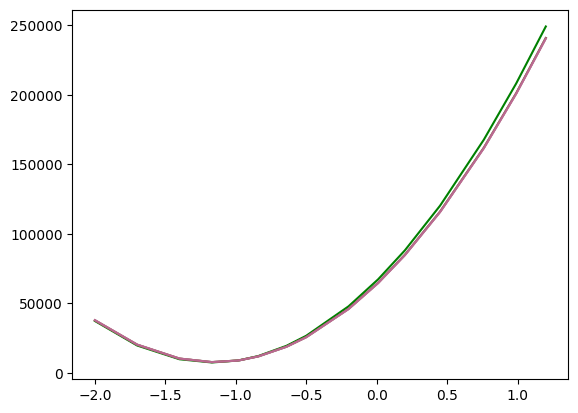

In [44]:
plt.plot(np.array(coefs), np.array(losses), label='MSE', color='green')
coefs = [-2.0, -1.7, -1.4, -1.16981158, -0.99, -0.98, -0.97, -0.84, -0.64, -0.5, -0.2, 0.01, 0.2, 0.45, 0.76, 0.99, 1.2]

losses_ridge_all = [losses]
train_data_ridge = train_data[:]
for i in [0, 500, 2000, 3000, 4000, 5000, 10000]:
    model_ridge = Ridge(alpha=i).fit(x,y)
    
    x_test = train_data_ridge['checkout_price'].to_numpy().reshape(-1,1)
    train_data_ridge["predictions"] = model_ridge.predict(x_test)
    mean_squared_error_test_ridge = mean_squared_error(train_data_ridge["num_orders"], train_data_ridge['predictions'])
    #print(f'Alpha {i}, Test Ridge {mean_squared_error_test_ridge=}')
    
    models_ridge = []
    for coef in coefs:
        new_model = deepcopy(model_ridge)
        new_model.coef_ = np.array([coef])
        models_ridge.append(new_model)
        
    for j in range(len(models_ridge)):
        train_data_ridge[f"exp_{j}"] = models_ridge[j].predict(x_test)
        
    losses_ridge = []
    for j, model in enumerate(models_ridge):
        losses_ridge.append(mean_squared_error(train_data_ridge["num_orders"], train_data_ridge[f"exp_{j}"]))
        #print(f'Model {j}, coef={models_ridge[j].coef_}, Test MSE={losses_ridge[-1]}')
    
    losses_ridge_all.append(losses_ridge)
    plt.plot(np.array(coefs), np.array(losses_ridge), label='MSE', alpha=0.5)


In [45]:
for lst in losses_ridge_all:
    print(min(lst))

7477.105271260521
7740.8895035336745
7741.067897953157
7741.613647105861
7741.986270514505
7742.365913136424
7742.752563593184
7744.790536431289


# Hyperparameter tuning

Examples

* Параметр регуляризації $\lambda$
* Ступінь полінома в задачі регресії з сімейством алгоритмів, заданим безліччю поліномів деякого ступеня
* learning rate
* ...

# Training data / validation / test
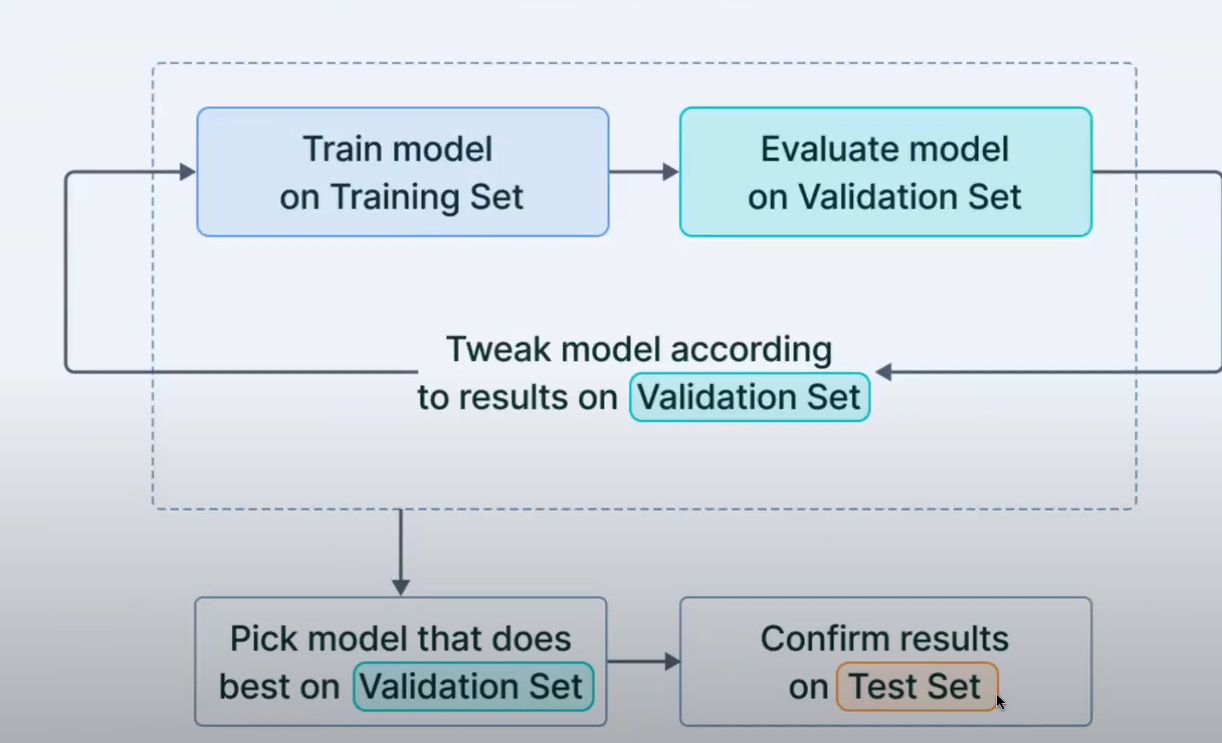

In [46]:
m = LinearRegression().fit(x, y)
x_test = test_data['checkout_price'].to_numpy().reshape(-1, 1)
y_test = test_data['num_orders'].to_numpy()
print(x_test.shape, y_test.shape)  # Should both be (320,)
# Ensure y_test is 1D for score()
m.score(x_test, y_test)  # the coefficient of determination R^2 of the prediction

(320, 1) (320,)


0.3928164914973644

In [47]:
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit



In [48]:
m = Ridge(3000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.30698381, 0.50082496, 0.44499188, 0.35442281, 0.36007613]),
 np.float64(0.39345991672494646))

In [49]:
m = Ridge(5000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.30709709, 0.50074665, 0.44506864, 0.35433073, 0.36016102]),
 np.float64(0.39348082388514605))

In [50]:
m = Lasso(2000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.29514926, 0.36162224, 0.3885103 , 0.24027339, 0.32038302]),
 np.float64(0.3211876406448347))

In [51]:
m = Lasso(4000)
scores = cross_val_score(m, x, y, cv=5)
scores, np.mean(scores)

(array([0.11312477, 0.05045328, 0.11787971, 0.02603968, 0.09051612]),
 np.float64(0.0796027141235982))

In [52]:
m = LinearRegression().fit(x, y)
x_test = test_data['checkout_price'].to_numpy().reshape(-1, 1)
y_test = test_data['num_orders'].to_numpy()
pred = m.predict(x_test)
sklearn.metrics.r2_score(y_test, pred)

0.3928164914973644